In [ ]:
!pip install resampy

import pandas as pd
import numpy as np
import glob
import os
import sys

import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
Ravdess = '/content/gdrive/MyDrive/datatset/RAVDESS/audio_speech_actors_01-24/'

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

In [ ]:
data_path = Ravdess_df
data_path.to_csv("data_path.csv",index=False)

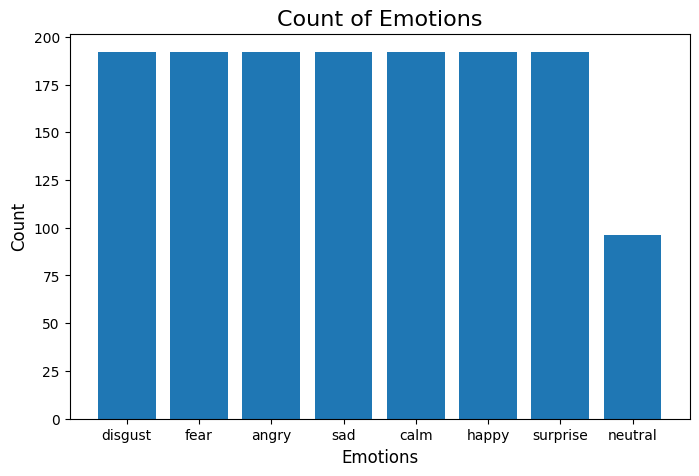

In [ ]:
emotion_counts = data_path.Emotions.value_counts()

plt.figure(figsize=(8, 5))
plt.title('Count of Emotions', size=16)
plt.bar(emotion_counts.index, emotion_counts.values)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

def plot_waveform_spectrogram(emotion):
    path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data, sampling_rate, emotion)
    create_spectrogram(data, sampling_rate, emotion)
    return Audio(path)

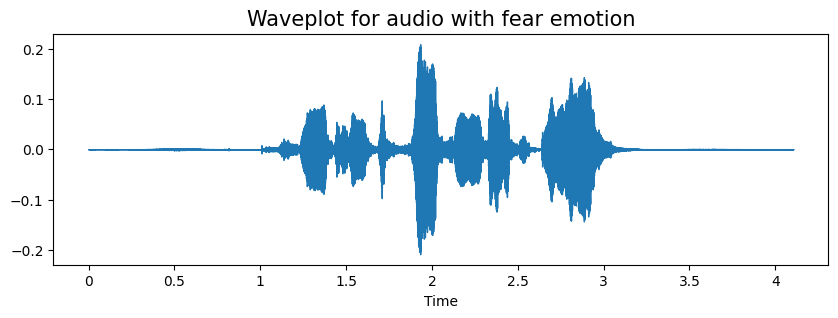

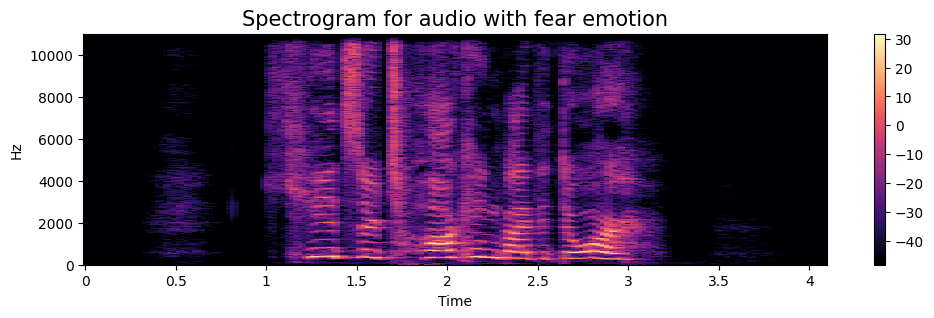

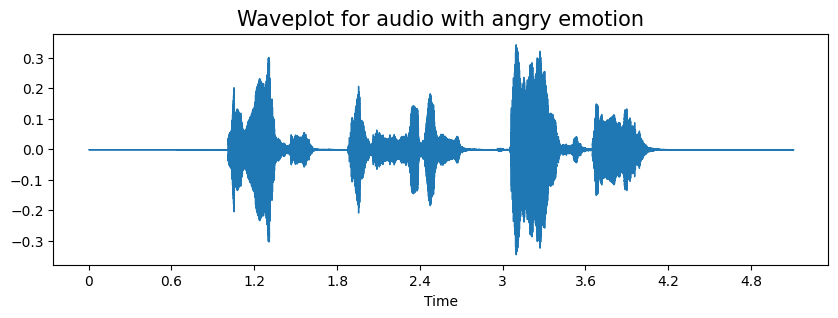

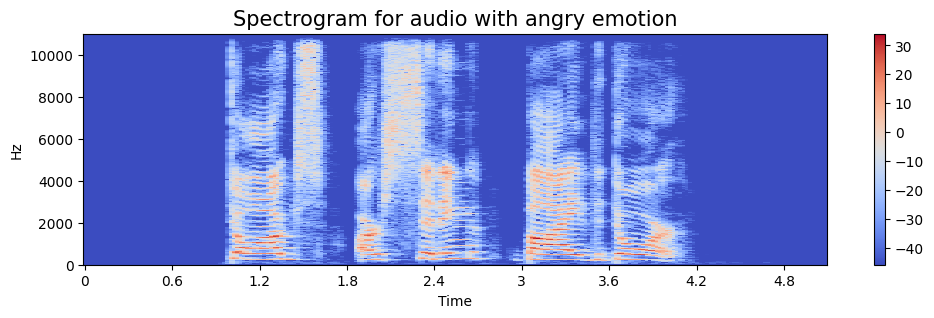

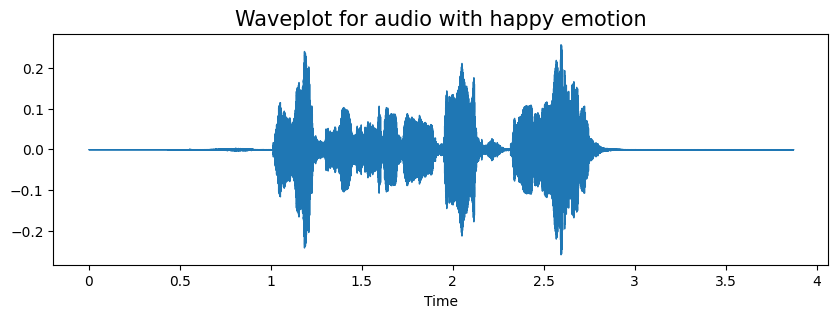

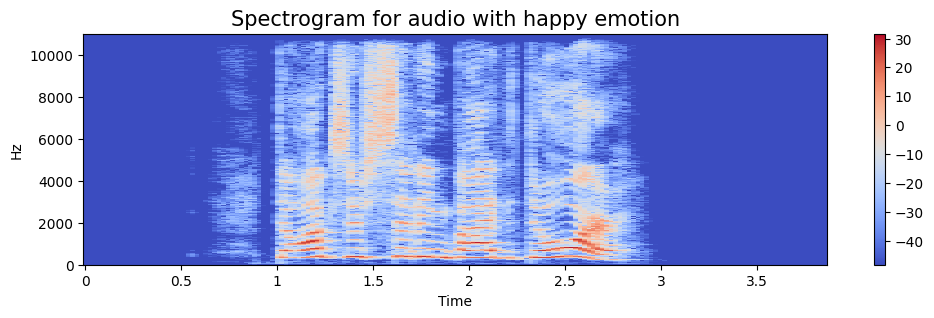

In [ ]:
plot_waveform_spectrogram('fear')
plot_waveform_spectrogram('angry')
plot_waveform_spectrogram('happy')

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
def extract_feature(file_name, mfcc, chroma, mel):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    if chroma:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        result = np.hstack((result, mel))
    return result

In [ ]:
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}
observed_emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

In [ ]:
def load_data(test_size=0.2):
    x, y = [], []
    for file in glob.glob(f"{Ravdess}/*/*.wav"):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
x_train, x_test, y_train, y_test = load_data(test_size=0.25)

In [ ]:
print((x_train.shape[0], x_test.shape[0]))

(1080, 360)


In [ ]:
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [ ]:
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500, random_state=42)

In [ ]:
model.fit(x_train, y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500, random_state=42)

In [ ]:
y_pred = model.predict(x_test)

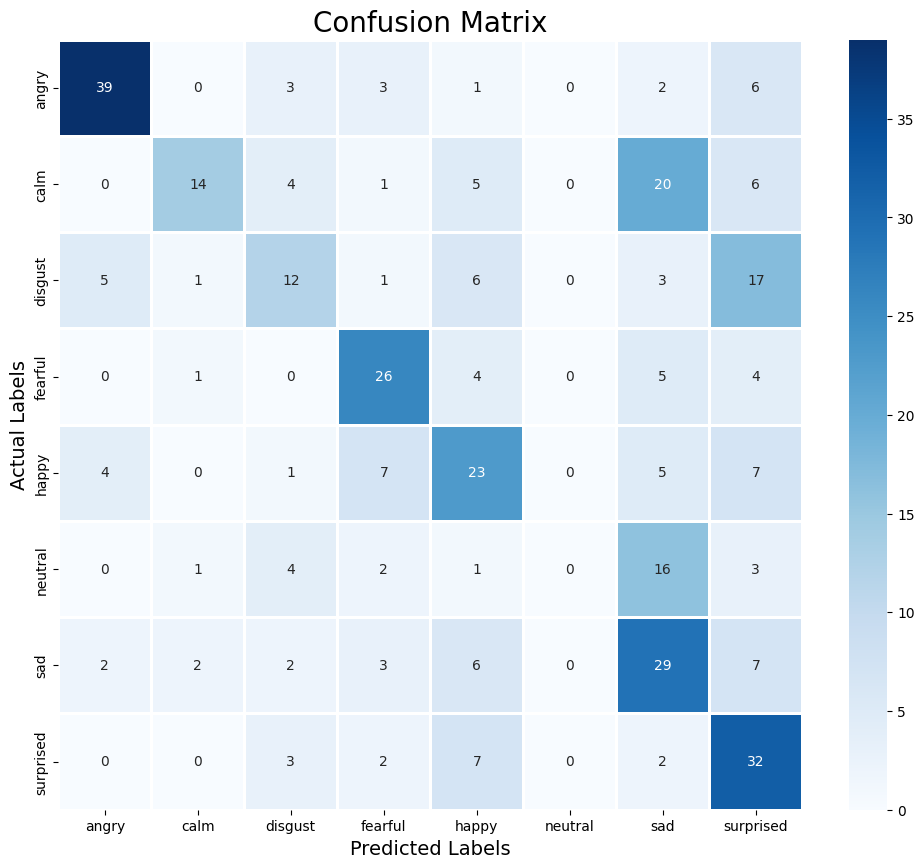

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
cm_df = pd.DataFrame(cm, index=[i for i in np.unique(observed_emotions)], columns=[i for i in np.unique(observed_emotions)])
sns.heatmap(cm_df, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

       angry       0.78      0.72      0.75        54
        calm       0.74      0.28      0.41        50
     disgust       0.41      0.27      0.32        45
     fearful       0.58      0.65      0.61        40
       happy       0.43      0.49      0.46        47
     neutral       0.00      0.00      0.00        27
         sad       0.35      0.57      0.44        51
   surprised       0.39      0.70      0.50        46

    accuracy                           0.49       360
   macro avg       0.46      0.46      0.44       360
weighted avg       0.49      0.49      0.46       360



In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 48.61%
